#***Regression for CO2.data***

In [1]:
#import packages
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (10,6)

df=pd.read_csv("CO2_Emissions_Canada.csv")
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


**Swapping function**

In [2]:

#swapping columns, shifting target column as first column
def swap_columns(df, c1, c2):
    col_list = list(df.columns)
    x, y = col_list.index(c1), col_list.index(c2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df
    

In [3]:
def mean_absolute_error(y_true,predictions):
  return np.mean(np.abs(y_true - predictions))


In [4]:

#analysing the data and checking for null values
df.head()
df.isna().sum()
df.nunique()
len(df)




7385

In [5]:

#shifting co2 emissions column as first column
df=swap_columns(df,"Make","CO2 Emissions(g/km)")
df.nunique()


CO2 Emissions(g/km)                  331
Model                               2053
Vehicle Class                         16
Engine Size(L)                        51
Cylinders                              8
Transmission                          27
Fuel Type                              5
Fuel Consumption City (L/100 km)     211
Fuel Consumption Hwy (L/100 km)      143
Fuel Consumption Comb (L/100 km)     181
Fuel Consumption Comb (mpg)           54
Make                                  42
dtype: int64


Correlation matrix


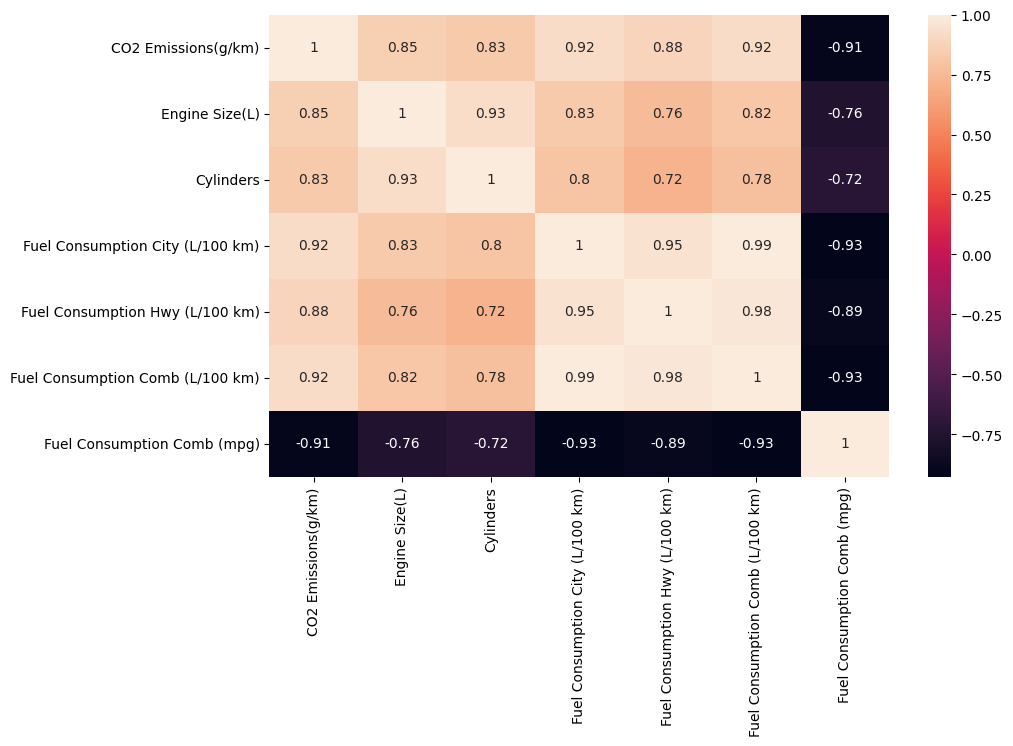

In [6]:

#correlation matrix
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()


#PREPROCESSING


Removing columns... and one hot encoding..


In [7]:

#removing unnecessary columns from dataframe 
df.drop(axis="columns", labels="Make", inplace=True)
df.drop(axis="columns", labels="Model", inplace=True)
df.drop(axis="columns", labels="Vehicle Class", inplace=True)
#df.drop(axis="columns", labels="Transmission", inplace=True)

#using one hot encoding for fuel type and transmission columns
column_names_to_one_hot=["Fuel Type","Transmission"]
df = pd.get_dummies(df, columns=column_names_to_one_hot)
df.head()


,CO2 Emissions(g/km),Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),Fuel Type_D,Fuel Type_E,Fuel Type_N,...,Transmission_AS8,Transmission_AS9,Transmission_AV,Transmission_AV10,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7
0,196,2.0,4,9.9,6.7,8.5,33,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,221,2.4,4,11.2,7.7,9.6,29,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,136,1.5,4,6.0,5.8,5.9,48,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,255,3.5,6,12.7,9.1,11.1,25,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,244,3.5,6,12.1,8.7,10.6,27,0,0,0,...,0,0,0,0,0,0,0,0,0,0


removing duplicates...

In [8]:

#removing duplicates
df.duplicated().sum()
df.drop(axis="rows", labels=df.index[df.duplicated()], inplace=True)
df.duplicated().sum()
df.shape[1]


39

Seperating target column and features

In [9]:

#seperating X and Y 
# adding a column of 1's
#X=np.ones((len(df),40))

X=df.iloc[:,1:df.shape[1]+1]

#standarize the data and a add a column of 1's as a constant
X = (X - X.mean())/X.std()
X.insert(df.shape[1]-1, "Const", [1]*len(X), True)
Y=df.iloc[:,0]
#print(X)


Splitting train and test data

In [10]:

#splitting data 
np.random.seed(94)
arr = np.random.rand(X.shape[0])
split = arr < np.percentile(arr,89)
X_train = X[split]
Y_train = Y[split]
X_test =  X[~split]
Y_test = Y[~split]


#***UNIVARIATE LINEAR REGRESSION : CLOSED FORM***

data for univariate regression

In [11]:

#column -3rd as the correclation bw 3 (or 5th) is greater with CO2 emissions
X_uni = df.iloc[:,[3]]
X_uni = (X_uni - X_uni.mean())/X_uni.std()
X_uni.insert(1, "Const", [1]*len(X_uni), True)
X_uni.nunique()
X_uni_tr=X_uni[split]
X_uni_te=X_uni[~split]


In [12]:

#formula for closed form regression
weightx= np.linalg.inv(X_uni_tr.T@X_uni_tr)@(X_uni_tr.T@Y_train)

Y_pred = (  X_uni_te @ weightx)
#print(Y_pred)



Mean Square Error:  594.0381937126144
Mean Absolute Error:  14.663427474262262


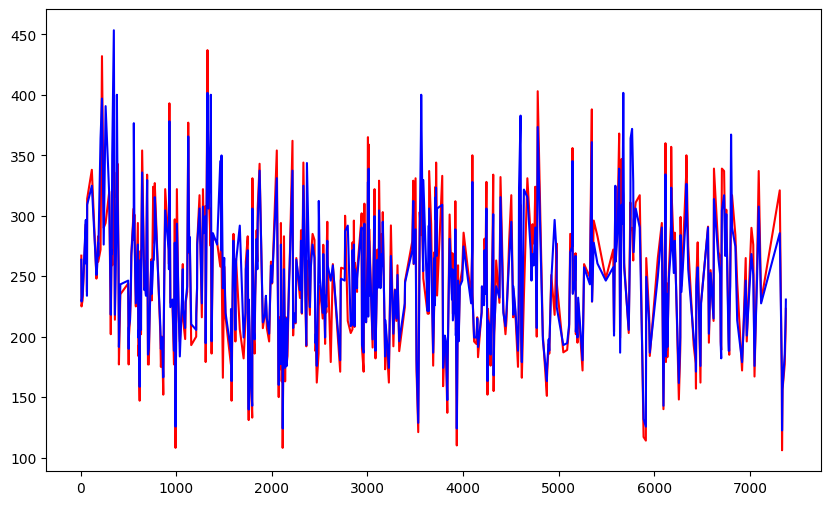

In [13]:

plt.plot(Y_test, color = "red")
plt.plot(Y_pred, color = "blue")
MSE = np.square(np.subtract(Y_test,Y_pred)).mean()
print("Mean Square Error: ", MSE)
mae=mean_absolute_error(Y_test,Y_pred)
#print(mae)
print("Mean Absolute Error: ", mae)


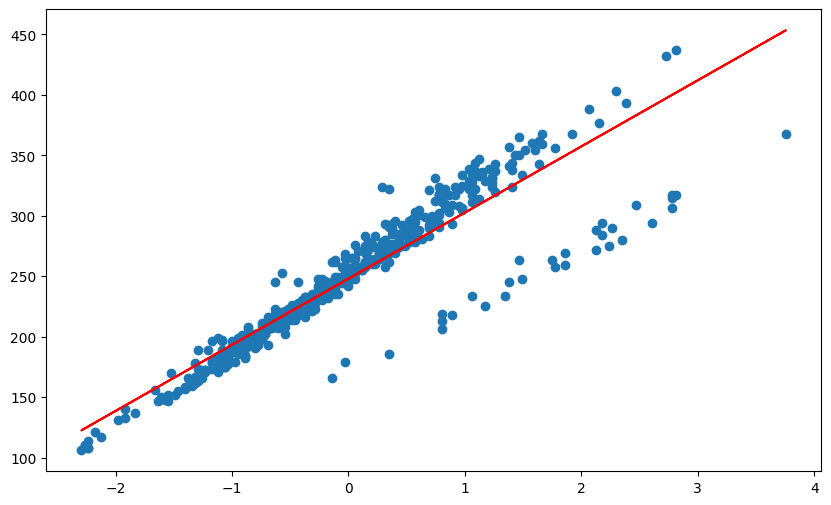

In [14]:
plt.scatter(X_test.loc[:,"Fuel Consumption City (L/100 km)"],Y_test)
plt.plot(X_test.loc[:,"Fuel Consumption City (L/100 km)"],Y_pred,color="red")
plt.show()

#***MULTIVARIATE LINEAR REGRESSION : Closed form***

*heart of linear regression*

In [15]:

mat=X_train.T@X_train
ir=np.identity(X_train.shape[1])
ir+=0.0001
mat+=ir
mat=np.linalg.inv(mat)
mat=mat@(X_train.T@Y_train)
Y_pred=X_test@mat


Plot b/w predicted data and actual data

Mean Square Error  26.876641213389586
Mean Absolute Error:  3.2472669670416523


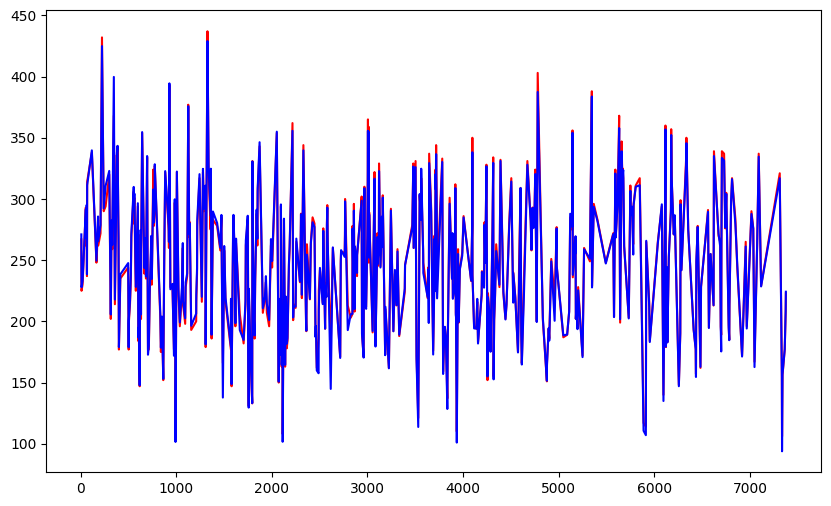

In [16]:

#print(mat)
plt.plot(Y_test, color = "red")
plt.plot(Y_pred, color = "blue")
MSE = np.square(np.subtract(Y_test,Y_pred)).mean()
print("Mean Square Error ", MSE)
mae=mean_absolute_error(Y_test,Y_pred)
print("Mean Absolute Error: ", mae)
#print(mae)


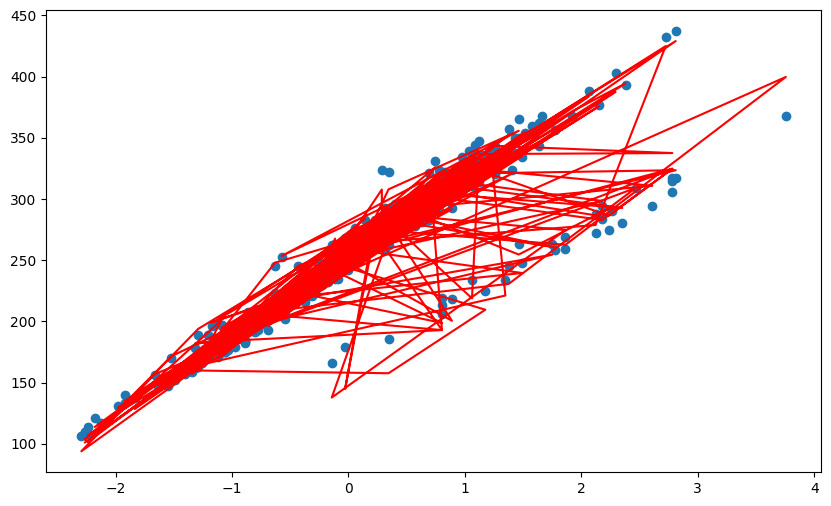

In [17]:
plt.scatter(X_test.loc[:,"Fuel Consumption City (L/100 km)"],Y_test)
plt.plot(X_test.loc[:,"Fuel Consumption City (L/100 km)"],Y_pred,color="red")
plt.show()

#***Gradient descent***

**UNIVARIATE LINEAR REGRESSION : gradient descent **

In [18]:

l_rate=0.01

X_uni_tr=X.iloc[:,[3]]
X_uni_te=X.iloc[:,[3]]
X_uni_tr.insert(1, "Const", [1]*len(X_uni_tr), True)
X_uni_te.insert(1, "Const", [1]*len(X_uni_te), True)
X_uni_tr=X_uni_tr[split]
X_uni_te=X_uni_te[~split]

rows=X_uni_tr.shape[0]


In [19]:

#W=np.random.uniform(low=0,high=2,size=2)
W=[0,0]
costs=[]

#W is the co efficients or the predicted co-relation
#grad is the gradient that to be reduced.. 

for i in range(1000):
    y_t=X_uni_tr@W
    #print(Y_train)
    #print(y_t)
    cost=np.mean((y_t-Y_train)**2)
    costs.append(cost)
    grad=(X_uni_tr.T)@(y_t-Y_train)
    W=W-1*l_rate/rows*grad
    
Y_pred=X_uni_te@W
#print(Y_pred)



Mean Square Error :  756.1140717688158
Mean Absolute Error:  18.766331411368277


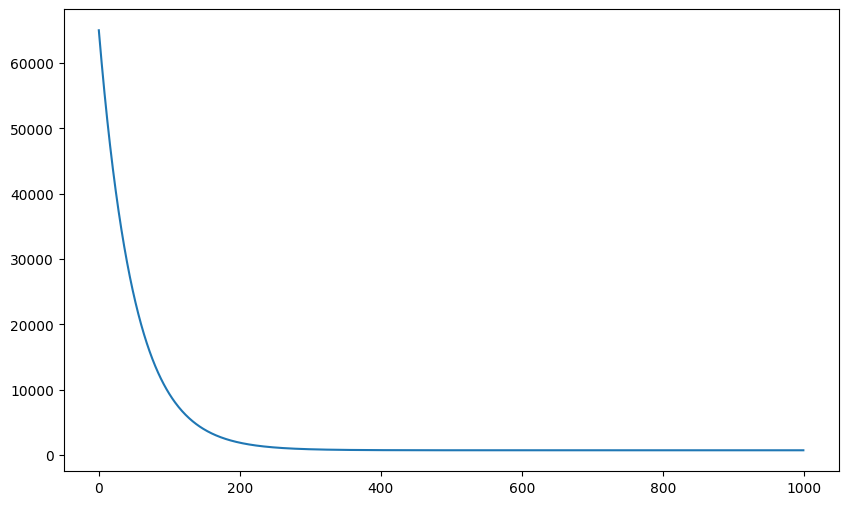

In [20]:

MSE = np.square(np.subtract(Y_test,Y_pred)).mean()
print("Mean Square Error : ", MSE)
plt.plot(costs)

mae=mean_absolute_error(Y_test,Y_pred)
#print(mae)
print("Mean Absolute Error: ", mae)
plt.show()


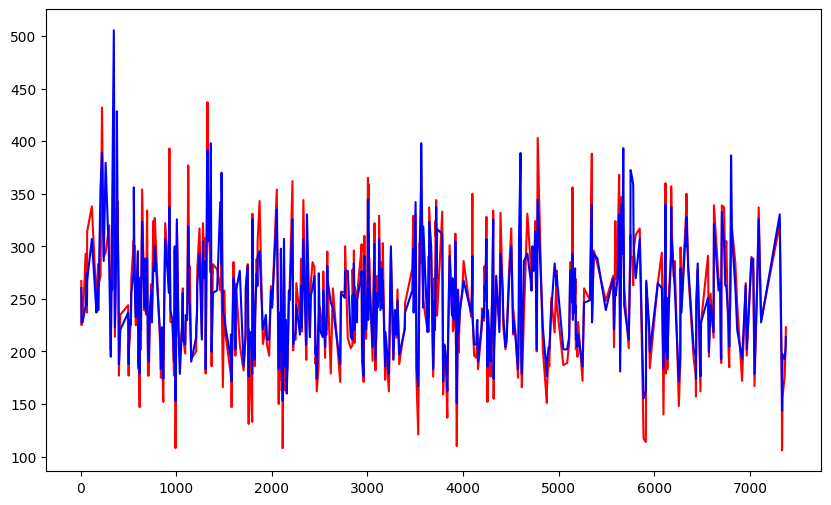

In [21]:
plt.plot(Y_test, color = "red")
plt.plot(Y_pred, color = "blue")
plt.show()

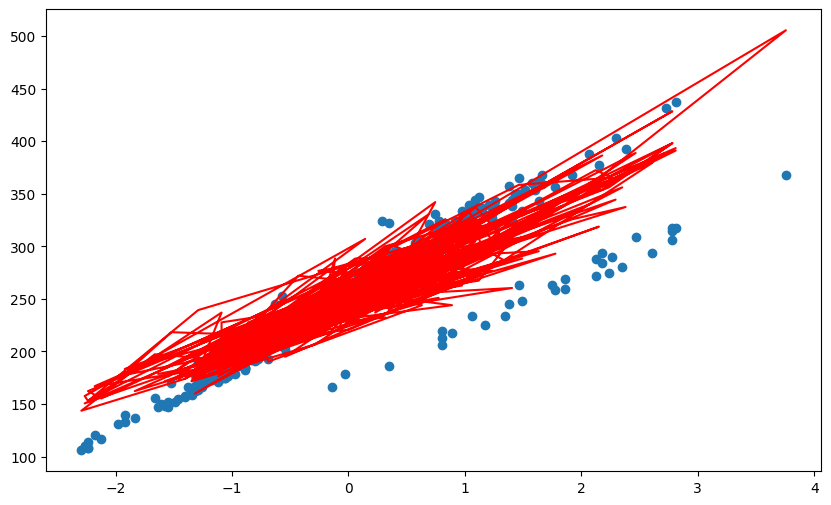

In [22]:
plt.scatter(X_test.loc[:,"Fuel Consumption City (L/100 km)"],Y_test)
plt.plot(X_test.loc[:,"Fuel Consumption City (L/100 km)"],Y_pred,color="red")
plt.show()

**MULTIVARIATE LINEAR REGRESSION : gradient descent **

In [23]:
#learning rate
l_rate=0.003

rows=X_train.shape[0]
#print(X_uni_tr.shape[1])

#a row of random values bw 0 and 1
W=np.random.uniform(low=0,high=1,size=X_train.shape[1])

#storing costs
costs=[]

In [24]:
for i in range(10000):
    y_t=X_train@W
    cost=np.mean((y_t-Y_train)**2)
    costs.append(cost)
    grad=(X_train.T)@(y_t-Y_train)
    W=W-1*l_rate/rows*grad
    
#optimising W as the iteration goes on....
Y_pred=X_test@W
#print(Y_pred)

plot for *actual(blue)* and *predicted(red)*

Mean Square 28.835648093593942
Mean Absolute Error:  3.473828618910859


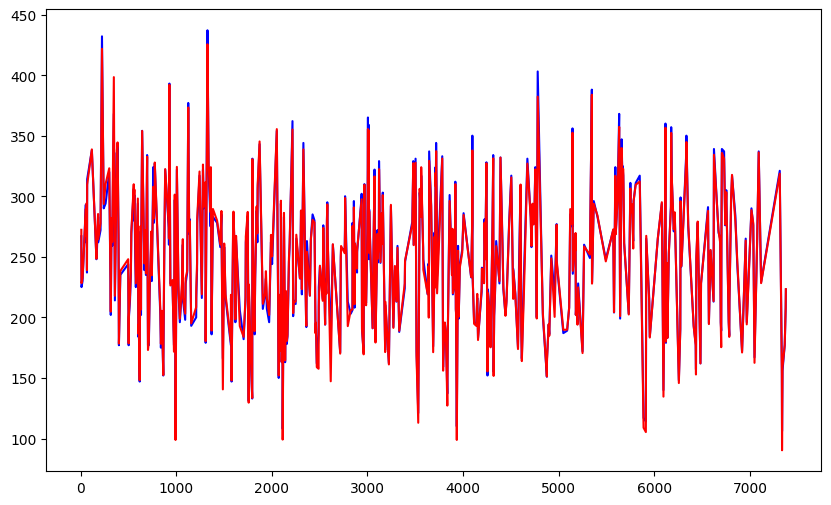

In [25]:
MSE = np.square(np.subtract(Y_test,Y_pred)).mean()
print("Mean Square", MSE)
plt.plot( Y_test,color="blue")
plt.plot(Y_pred, color="red")

mae=mean_absolute_error(Y_test,Y_pred)
print("Mean Absolute Error: ", mae)

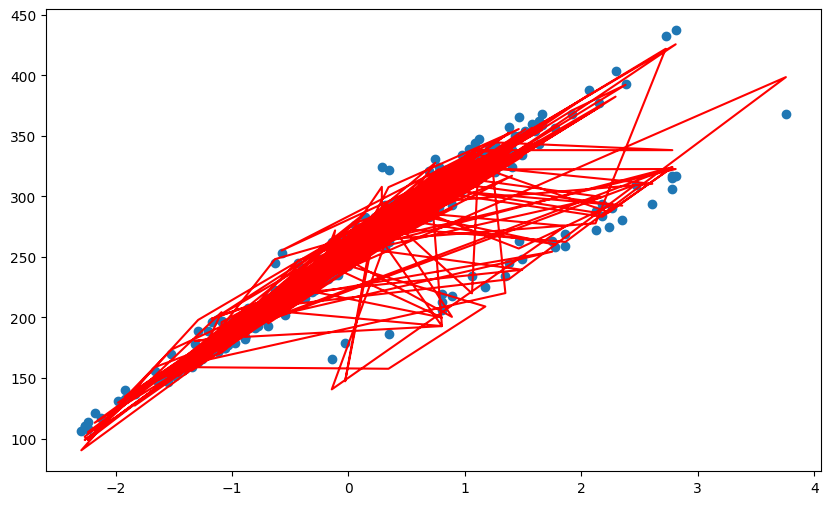

In [26]:
plt.scatter(X_test.loc[:,"Fuel Consumption City (L/100 km)"],Y_test)
plt.plot(X_test.loc[:,"Fuel Consumption City (L/100 km)"],Y_pred,color="red")
plt.show()

*plot of costs...*

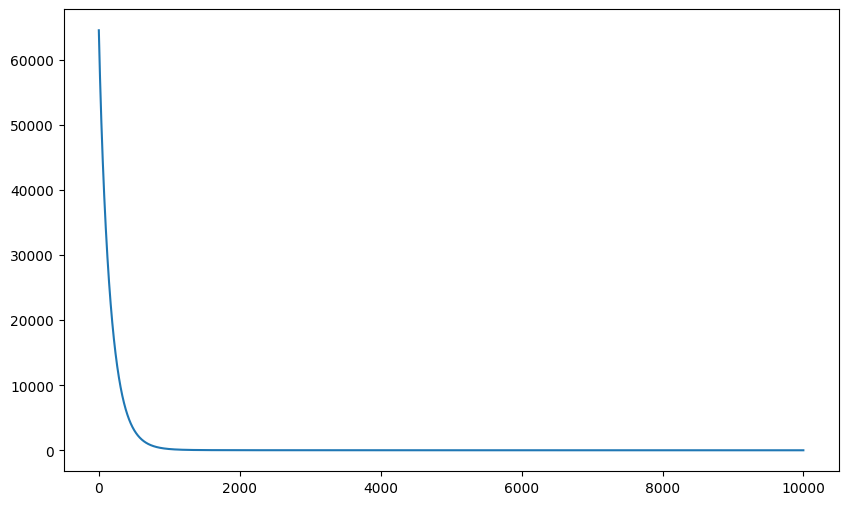

In [27]:

plt.show()

#plotting costs
plt.plot(costs)
plt.show()